In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",
                            username="root",
                            password="Shubham@2000",
                            database="ecommerce")

cur=db.cursor()

# list all unique cities where customers are located.

In [6]:
querry=""" select distinct customer_city from customers """

cur.execute(querry)

data= cur.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders placed in 2017

In [7]:
querry=""" select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute(querry)

data= cur.fetchall()

"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 45101)

# find the total sales per catagory

In [27]:
querry=""" select upper(products.product_category)  category, 
round(sum(payments.payment_value),2)  sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
"""

cur.execute(querry)

data= cur.fetchall()

df= pd.DataFrame(data, columns=["category","sales"])
df

,category,sales
0,PERFUMERY,4560647.94
1,FURNITURE DECORATION,12871587.53
2,TELEPHONY,4381938.46
3,BED TABLE BATH,15412983.04
4,AUTOMOTIVE,7670648.98
...,...,...
69,CDS MUSIC DVDS,10794.87
70,LA CUISINE,26221.77
71,FASHION CHILDREN'S CLOTHING,7071.03
72,PC GAMER,19569.87


# calculate the percentage of orders that we have paid in installments

In [10]:
query =""" select (sum(case when payment_installments >=1 then 1 
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data= cur.fetchall()
"the percentage of orders that we have paid in installments is", data[0][0]

('the percentage of orders that we have paid in installments is',
 Decimal('99.9981'))

# count the number of customer from each state

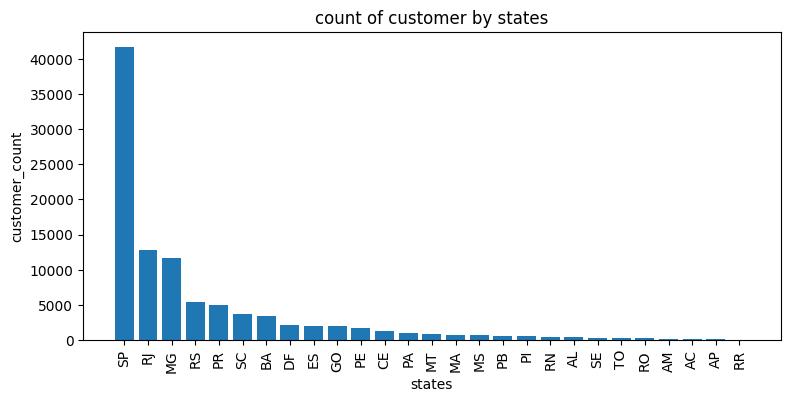

In [32]:
query =""" select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count" ])
df= df.sort_values(by="customer_count", ascending=False)
plt.figure(figsize=(9,4))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation =90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customer by states")
plt.show()


# calculate the number of orders per month in 2018

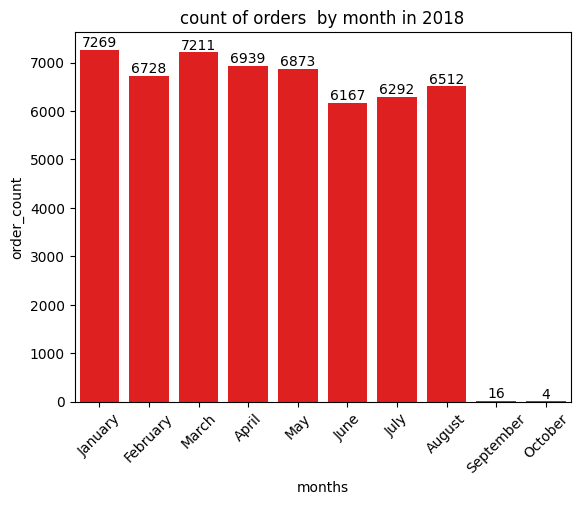

In [38]:
query =""" select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year (order_purchase_timestamp)=2018
group by months
"""

cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data, columns=["months", "order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]

ax=sns.barplot(x = df["months"],y = df["order_count"], data= df, order=o, color= "red")
plt.xticks(rotation=45)
ax.bar_label( ax.containers[0])
plt.title("count of orders  by month in 2018")
plt.show()

# find the average number of products per order,grouped by customer city

In [46]:
query =""" with count_per_order as 
(select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)
select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id= count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data,columns = ["customer city","average products/orders"])
df.head(10)

,customer city,average products/orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# calculate the percentage of total revenue contributed by each product category

In [7]:
query="""select upper(products.product_category)  category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales_percentage desc"""
cur.execute(query)

data= cur.fetchall()
data
df= pd.DataFrame(data,columns = ["category","percentage distribution"])
df.head()

,category,percentage distribution
0,BED TABLE BATH,32.09
1,HEALTH BEAUTY,31.06
2,COMPUTER ACCESSORIES,29.71
3,FURNITURE DECORATION,26.80
4,WATCHES PRESENT,26.78


# Identify the correlation between product price and the number of times a product has been purchased

In [5]:
query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data,columns = ["category","order_count","price"])
df
arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is",a[0][1])

the correlation between price and number of times a product has been purchased is -0.1063151416715756


# calculate the total revenue generated by each seller ,and rank them by revenue

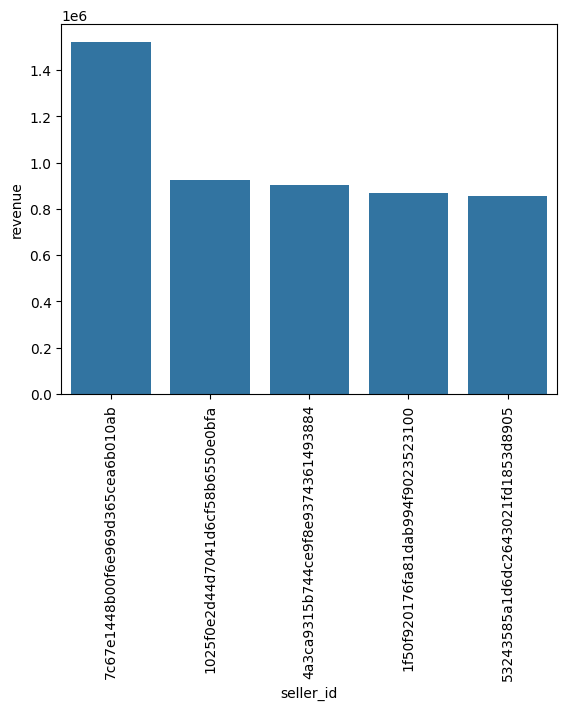

In [14]:
query="""select*,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x = "seller_id", y = "revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# calculate the moving average of order values for each customer over their order history

In [15]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a"""
cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","history on timestamp","price","mov_avg"])
df=df.head()

# calculate the cumalitive sales per month for each year

In [22]:
query="""select years,months, payment, sum(payment)
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years,months) as a"""
cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data,columns=["years","months","payment","cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,756.72,756.72
1,2016,10,177271.44,178028.16
2,2016,12,58.86,178087.02
3,2017,1,415464.12,593551.14
4,2017,2,875724.03,1469275.17
5,2017,3,1349590.80,2818865.97
6,2017,4,1253364.09,4072230.06
7,2017,5,1778756.46,5850986.52
8,2017,6,1533829.14,7384815.66
9,2017,7,1777148.76,9161964.42


# calculate the year_over_year growth rate

In [8]:
query="""with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years order by years)

select years, ((payment-lag(payment,1) over(order by years))/
lag(payment,1) over(order by years)) * 100 from a"""

cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703756
2,2018,20.000924


# calculate the retention rate of customers,defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [5]:
query="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp>first_order
and orders.order_purchase_timestamp<
date_add(first_order, interval 6 month)
group by a.customer_id)
select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id"""
cur.execute(query)
data= cur.fetchall()
data #since none of customers repeated so it is null

[(None,)]

# identify the top 3 customers who spent the most money in each year

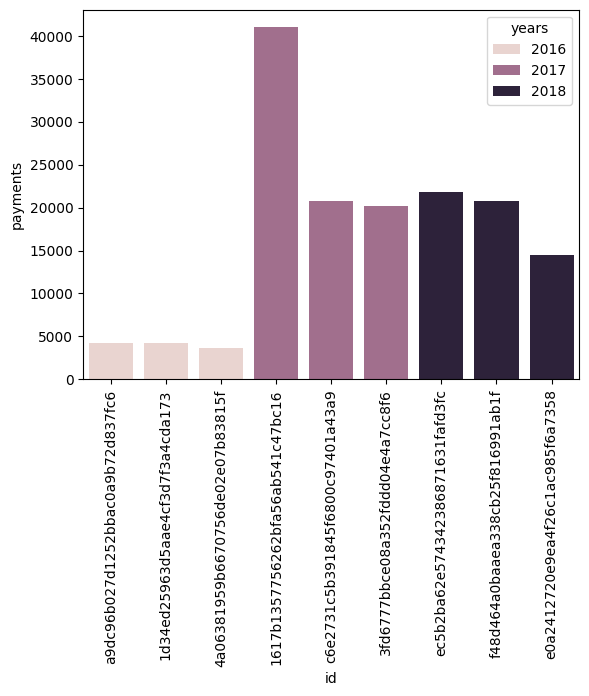

In [10]:
query="""select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank<=3"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=["years","id","payments","rank"])
sns.barplot(x="id", y="payments",data=df,hue="years")
plt.xticks(rotation=90)
plt.show()